In [5]:
pip install -q yfinance

Note: you may need to restart the kernel to use updated packages.


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import statsmodels.tsa.holtwinters as ets
import statsmodels.tools.eval_measures as fa
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from   statsmodels.tsa.holtwinters import  SimpleExpSmoothing

import sys
import warnings
import itertools
warnings.filterwarnings("ignore")

import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf

from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima


In [6]:
import pandas_datareader as web
import yfinance as yf

In [46]:
df = yf.download('GE', start='1999-09-10', end='2022-10-09')

[*********************100%***********************]  1 of 1 completed


In [47]:
df_new = df[['Close']].copy()

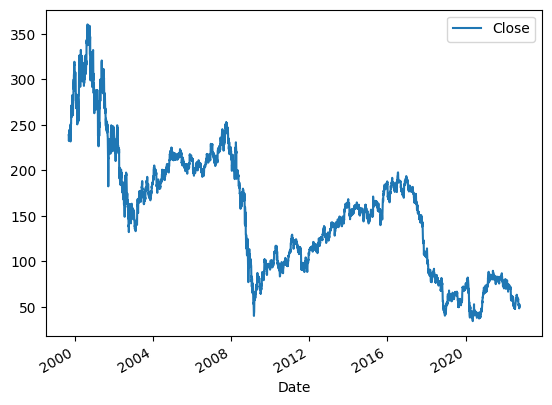

In [48]:
df_new.plot()
plt.show()

In [49]:
df_new.head()

,Close
Date,
1999-09-10,238.570633
1999-09-13,237.319595
1999-09-14,233.691620
1999-09-15,232.190399
1999-09-16,234.692444


In [50]:
df_new.isna().sum()

Close    0
dtype: int64

In [38]:
def MAPE(close, pred_close):
    close, pred_close = np.array(close),np.array(pred_close)
    mape = round(np.sum(np.abs(pred_close-close))/np.sum(close)*100,2)
    return print(f'The MAPE value is : {mape}')

def RMSE(close, pred_close):
    rmse = np.sqrt(mean_squared_error(close,pred_close))
    return print(f'The RMSE value is : {rmse}')

def graphplot(x):
    plt.figure(figsize=(16,8))
    plt.plot(train, label="Train")
    plt.plot(test, label='Test')
    plt.plot(x, label='Forecast')
    plt.legend(loc='best')
    return plt.show()

In [51]:
class stockmodels:
    def __init__(self,my_dataframe):
        self.df = df
        pass
    
    def additive_SD(self):
        ##Additive Decomposition
        result = seasonal_decompose(df_new,model='additive',period=1000)
        result.plot()
        return plt.show()
    
    def multiplicative_SD(self):
        #Multiplicative Decomposition
        result_m = seasonal_decompose(df_new, model='multiplicative', period=500)
        result_m.plot()
        return plt.show()

    def ADFtest(self):
        from statsmodels.tsa.stattools import adfuller
        result_adf= adfuller(df_new,autolag='AIC')
        print(f'ADF Statistic:{result_adf[0]}')
        print(f'p-value:{result_adf[1]}')
        print(f'nlag:{result_adf[2]}')
        print(f'nobs:{result_adf[3]}')
        for key, value in result_adf[4].items():
            print(f'Critical value: {key}, {value}')
        ## Insert the results or implications
    
    def KPSStest(self):
        from statsmodels.tsa.stattools import kpss
        result_kpss = kpss(df_new)
        print(f'KPSS Statistic:{result_kpss[0]}')
        print(f'p-value:{result_kpss[1]}')
        print(f'nlag:{result_kpss[2]}')
        for key, value in result_kpss[3].items():
            print(f'Critical value: {key}, {value}')
        ## Insert the results or implications
    
    def score(self, close, pred_close):
        close, pred_close = np.array(close),np.array(pred_close)
        mape = round(np.sum(np.abs(pred_close-close))/np.sum(close)*100,2)
        rmse = np.sqrt(mean_squared_error(close,pred_close))
        print(f'The MAPE value is : {mape}')
        print(f'The RMSE value is : {rmse}')

    def graphplot(self,x):
        plt.figure(figsize=(16,8))
        plt.plot(train, label="Train")
        plt.plot(test, label='Test')
        plt.plot(x, label='Forecast')
        plt.legend(loc='best')
        return plt.show()
    
    def traintestsplit(self):
        global train, test
        train = df_new[0:int(len(df_new)*0.7)] 
        test = df_new[int(len(df_new)*0.7):]
        return print('The dataset is split into train and test - 70:30')
    
    def naive_forecast(self):
        train_nf = np.asarray(train.Close)
        test_nf = test.copy()
        test_nf['Naive']=train_nf[len(train_nf)-1]
        self.graphplot(test_nf.Naive)
        self.score(test_nf.Close,test_nf.Naive)

    def simple_avg(self):
        test_sa=test.copy()
        test_sa['avg_forecast']=train['Close'].mean()
        self.graphplot(test_sa.avg_forecast)
        self.score(test_sa.Close,test_sa.avg_forecast)

    def moving_avg(self):
        df_ma=df_new.copy()
        
        df_ma['ma_forecast_4']=df_ma['Close'].rolling(4).mean()
        df_ma['ma_forecast_6']=df_ma['Close'].rolling(6).mean()
        df_ma['ma_forecast_8']=df_ma['Close'].rolling(8).mean()
        df_ma['ma_forecast_12']=df_ma['Close'].rolling(12).mean()
        ma_cols = ['ma_forecast_4','ma_forecast_6','ma_forecast_8','ma_forecast_12']

        #split the dataset into train and test
        train_ma=df_ma[0:int(len(df_ma)*0.7)]
        test_ma=df_ma[int(len(df_ma)*0.7):]

        for col_name in ma_cols:
            print('\n'+col_name)
            self.score(test_ma.Close,test_ma[col_name])
            plt.figure(figsize=(12,6))
            plt.plot(test_ma['Close'][:50], label='Test')
            plt.plot(test_ma[col_name][:50], label = 'Forecast_MV')
            plt.legend(loc='best')
            
    def exp_smooth(self):
        pred = ets.ExponentialSmoothing(df_new, trend=None, damped=False, seasonal=None).fit()
        close_pred = pred.forecast(steps=7)
        close_pred = pd.DataFrame(close_pred)
        pred_close = pred.predict(start=df_new.index[0])
        self.score(df_new.Close,pred_close)
        plt.figure(figsize=(12,6))
        plt.plot(df_new[:50], label='Test')
        plt.plot(pred_close[:50], label = 'Forecast')
        plt.legend(loc='best')


    def SES_1(self):
        model = SimpleExpSmoothing(np.asarray(train['Close']))
        #Fitting the model
        alpha_list = [0.1, 0.3, 0.5, 0.7, 0.99]

        pred_SES  = test.copy() 

        for alpha_value in alpha_list:
            alpha_str = "SES" + str(alpha_value)
            mode_fit_i = model.fit(smoothing_level = alpha_value, optimized=False)
            pred_SES[alpha_str] = mode_fit_i.forecast(len(pred_SES['Close']))
            print(alpha_value)
            self.score(pred_SES.Close,pred_SES[alpha_str])
            print('\n')
            
            plt.figure(figsize=(8,8))
            plt.plot(train, label ='Train')
            plt.plot(test, label  ='Test')
            plt.plot(pred_SES[alpha_str], label  = alpha_str)
            plt.title('Simple Exponential Smoothing with alpha ' + str(alpha_value))
            plt.legend(loc='best') 
            plt.show()
        
    def DES(self):
        model = Holt(np.asarray(train))
        model_fit = model.fit()

        alpha_value = np.round(model_fit.params['smoothing_level'], 4)
        print('Alpha Value', alpha_value )
        Pred_Holt = test.copy()
        Pred_Holt['Opt'] = model_fit.forecast(len(test['Close']))
        self.graphplot(Pred_Holt.Opt)
        self.score(test.Close,Pred_Holt['Opt'])

    def TES_add(self):
        model_esa = ExponentialSmoothing(np.asarray(train['Close']),seasonal_periods=2000, trend='add',seasonal='add').fit()
        test_esa['esa'] = model_esa.forecast(len(test_esa))
        alpha_value = np.round(model_esa.params['smoothing_level'], 4)
        gamma_value = np.round(model_esa.params['smoothing_seasonal'], 4)
        print(f'Alpha Value: {alpha_value}'+'\n'+'Beta Value: {bet_value}')
        self.graphplot(test_esa['esa'])
        self.score(test.Close,test_esa['esa'])
    
    def TES_mul(self):
        test_esm=test.copy()
        model_esm = ExponentialSmoothing(np.asarray(train['Close']),seasonal_periods=2000, trend='add',seasonal='multiplicative').fit()
        test_esm['esm'] = model_esm.forecast(len(test_esm))
        alpha_value = np.round(model_esm.params['smoothing_level'], 4)
        #beta_value  = np.round(model_esm.params['smoothing_slope'], 4)
        gamma_value = np.round(model_esm.params['smoothing_seasonal'], 4)
        print(f'Alpha Value: {alpha_value}'+'\n'+'Beta Value: {bet_value}')
        self.graphplot(test_esm['esm'])
        self.score(test.Close,test_esm['esm'])
        
    def roll_stats(self):
        #Determing rolling statistics
        rolmean = df_new.rolling(window = 5).mean()
        rolstd = df_new.rolling(window = 5).std()

        #Plot rolling statistics:
        orig = plt.plot(df_new[:100], label='Original')
        mean = plt.plot(rolmean[:100], label='Rolling Mean')
        std = plt.plot(rolstd[:100], label = 'Rolling Std')
        plt.legend(loc='best')
        plt.title('Rolling Mean & Standard Deviation')

    def diff_log(self):
        plt.figure(figsize=(8, 4))
        plt.plot(df_new.diff(periods=5))
        plt.title(label='Differencing')
        plt.xlabel('Years')
        plt.ylabel('Stocks Close')

        plt.figure(figsize=(8, 4))
        plt.plot(np.log10(df_new))
        plt.title(label='log')
        plt.xlabel('Years')
        plt.ylabel('Log (stock Close)')

        plt.figure(figsize=(10, 5))
        plt.plot(np.log10(df_new).diff(periods=1))
        plt.title(label='Differenced Log')
        plt.xlabel('Years')
        plt.ylabel('Differenced Log (Stock Close)')

    def ACF_PACF(self):
        close_log = np.log10(df_new)
        close_log.dropna(inplace=True)

        close_log_diff = close_log.diff(periods=1) 
        close_log_diff.dropna(inplace=True)

        fig, axes = plt.subplots(1, 2)
        fig.set_figwidth(12)
        fig.set_figheight(4)
        smt.graphics.plot_acf(close_log, lags=30, ax=axes[0])
        smt.graphics.plot_pacf(close_log, lags=30, ax=axes[1])
        plt.tight_layout()

        fig, axes = plt.subplots(1, 2)
        fig.set_figwidth(12)
        fig.set_figheight(4)
        plt.xticks(range(0,30,1), rotation = 90)
        smt.graphics.plot_acf(close_log_diff, lags=30, ax=axes[0])
        smt.graphics.plot_pacf(close_log_diff, lags=30, ax=axes[1])
        plt.tight_layout()
    
    def ARIMA_model(self):
        print('Identifying the best Model'+'\n')
        model_autoARIMA = auto_arima(train, start_p=0, start_q=0,test='adf', max_p=3, max_q=3,m=1,
                      d=None,
                      seasonal=False,
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
        print(model_autoARIMA.summary())
        model_autoARIMA.plot_diagnostics(figsize=(15,8))
        plt.show()

        model = sm.tsa.arima.ARIMA(train, order=(2,1,0))  
        fitted = model.fit()  
        print(fitted.summary())

        # Forecast
        fc = fitted.forecast(1801, alpha=0.3)  # 95% conf

        #Make as pandas series
        fc.index=test.index
        fc_series = fc.copy()

        # Plot
        plt.figure(figsize=(10,5), dpi=100)
        plt.plot(train, label='train')
        plt.plot(test, label='Actual Close Price')
        plt.plot(fc_series,label='Predicted')
        plt.xlabel('Time')
        plt.ylabel('Close stock price')
        plt.legend(loc='best')
        plt.show()

        a.score(test.Close,fc_series)


The dataset is split into train and test - 70:30


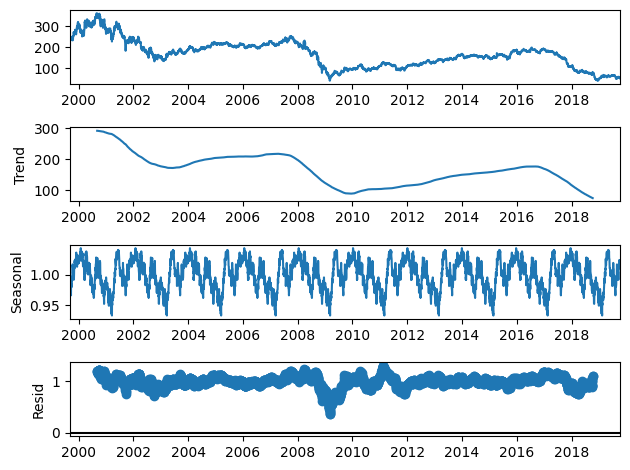

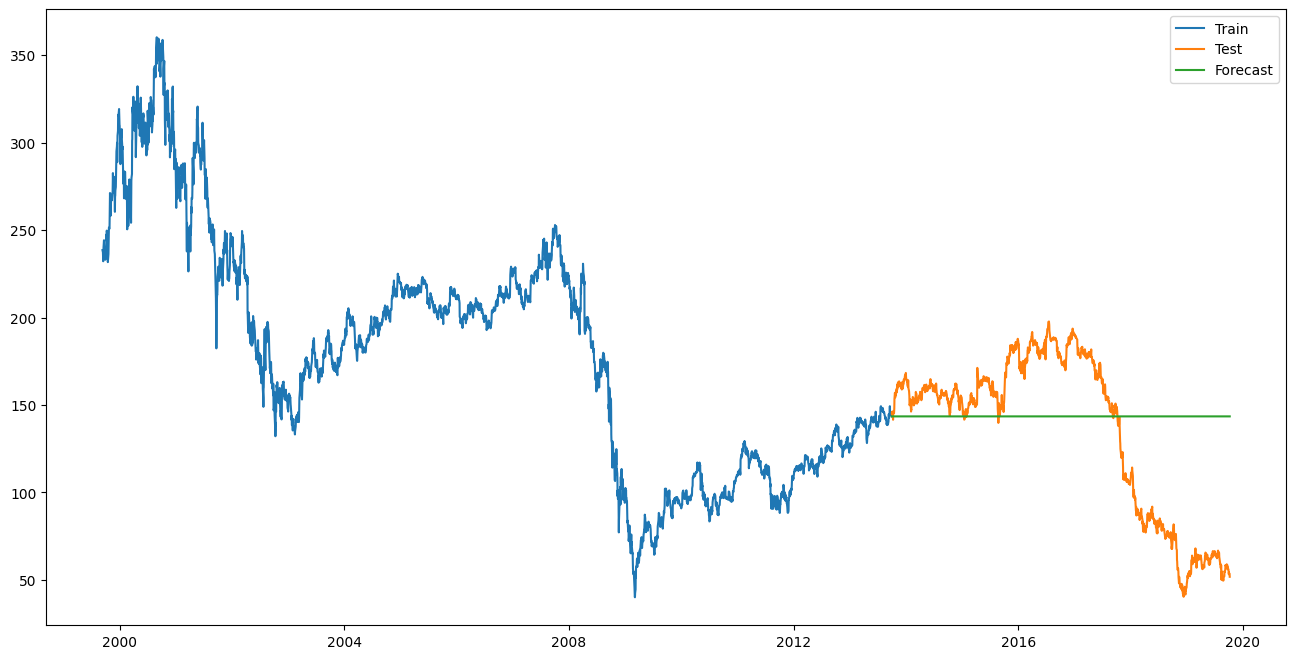

The MAPE value is : 27.81
The RMSE value is : 46.58268945436263


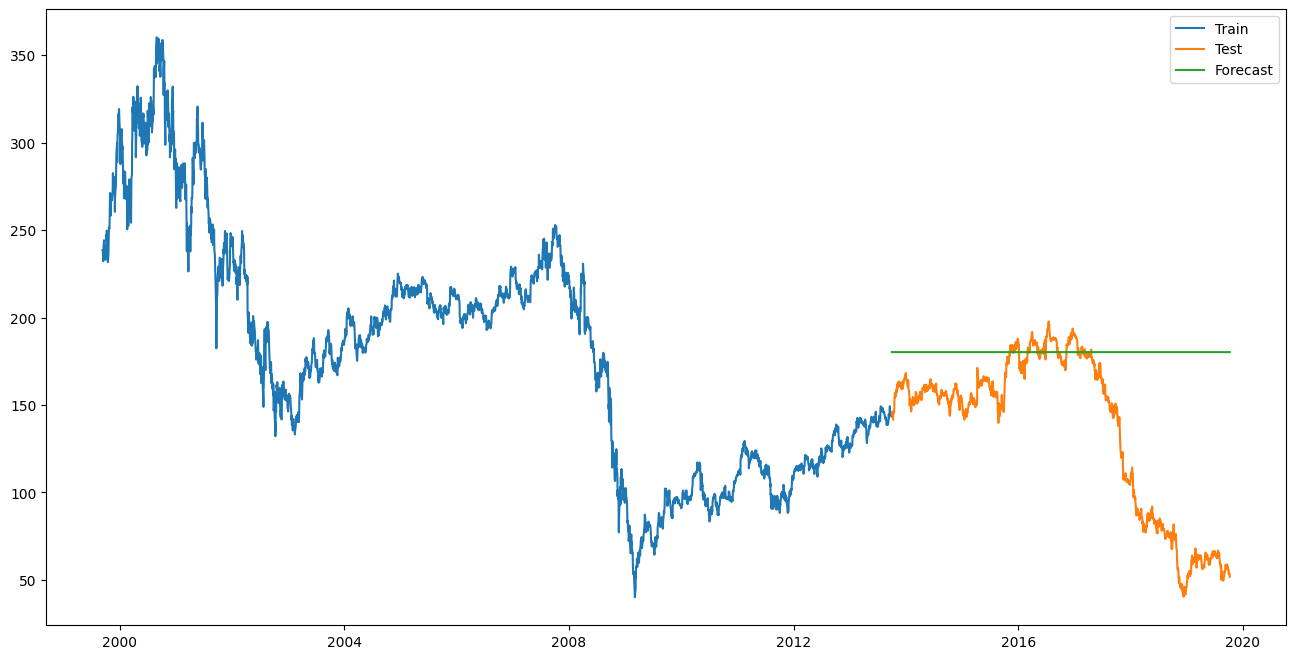

The MAPE value is : 33.8
The RMSE value is : 63.83161568354012

ma_forecast_4
The MAPE value is : 0.91
The RMSE value is : 1.728519834538327

ma_forecast_6
The MAPE value is : 1.24
The RMSE value is : 2.2956544970327064

ma_forecast_8
The MAPE value is : 1.5
The RMSE value is : 2.745116563501422

ma_forecast_12
The MAPE value is : 1.9
The RMSE value is : 3.450492728746229
The MAPE value is : 1.24
The RMSE value is : 3.227628846281506
0.1
The MAPE value is : 27.61
The RMSE value is : 46.72974271760531




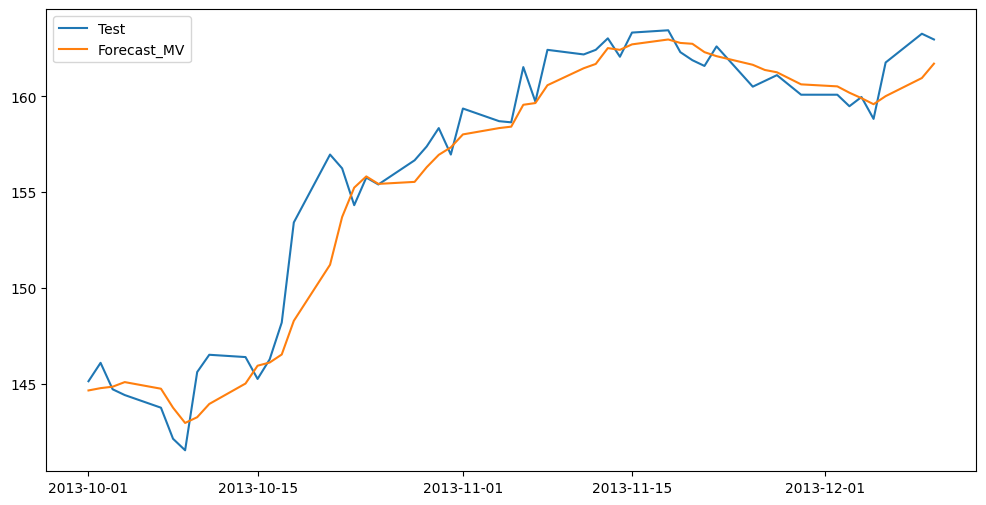

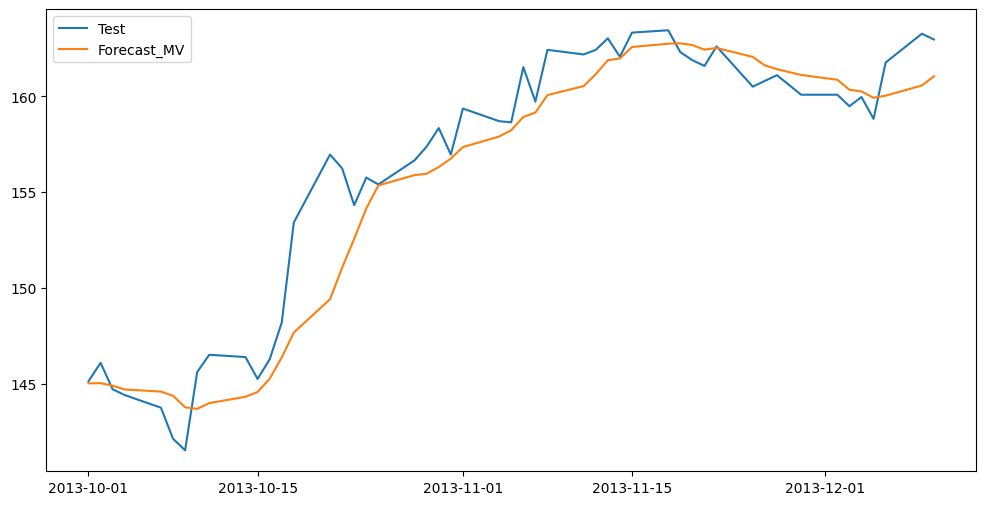

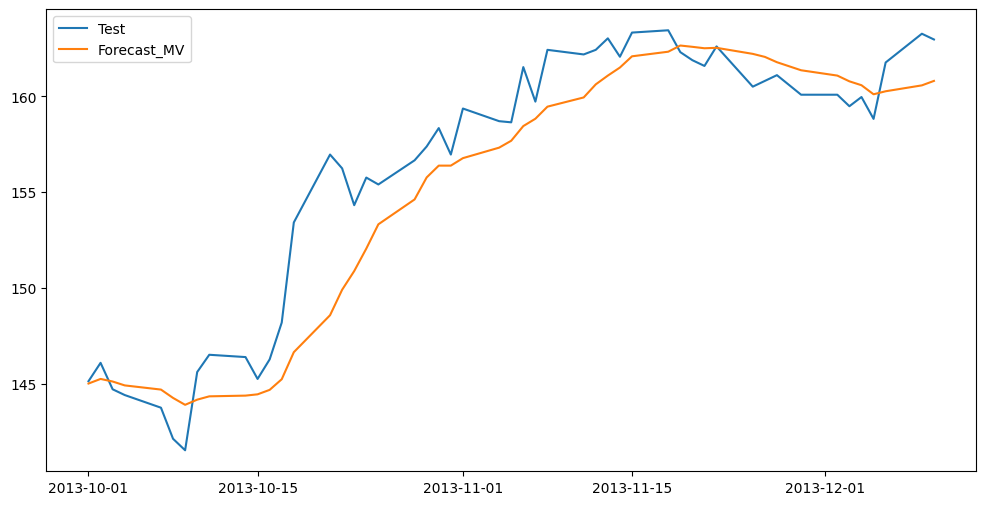

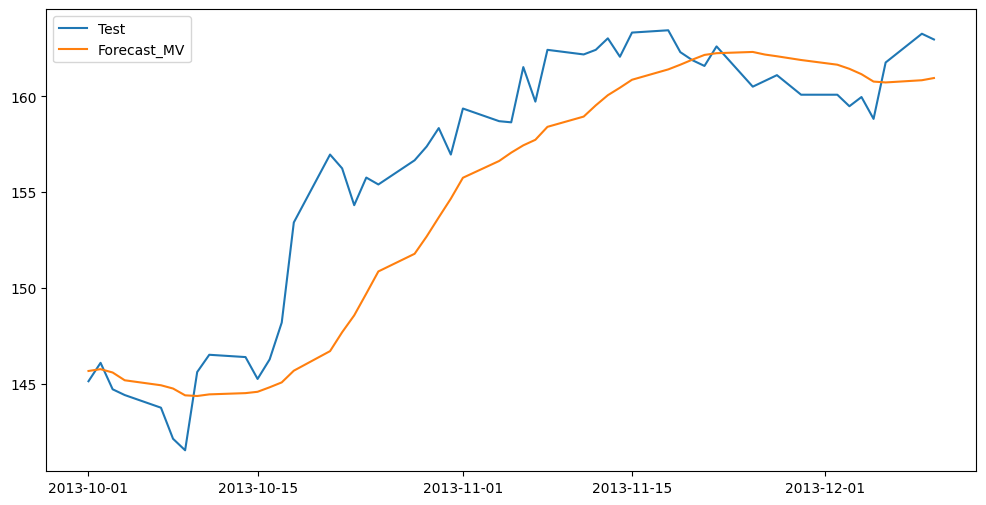

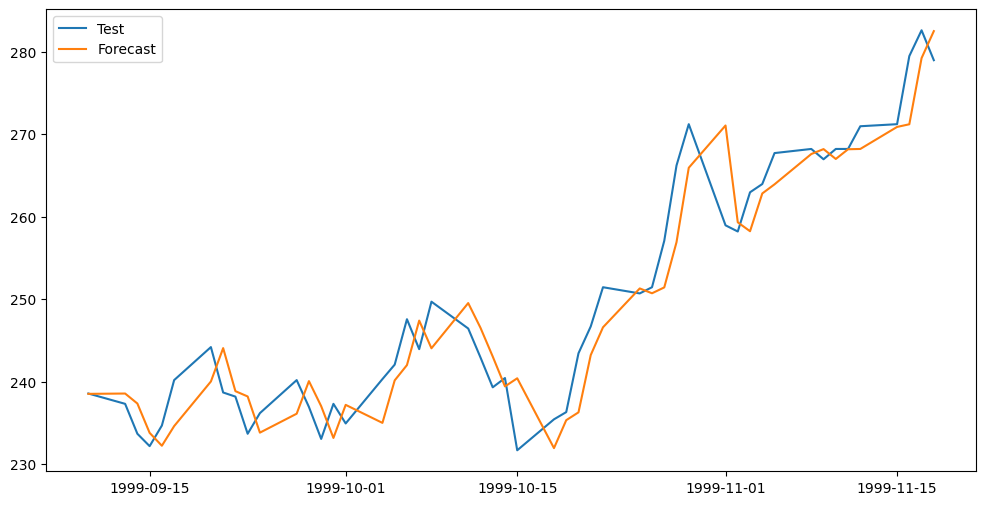

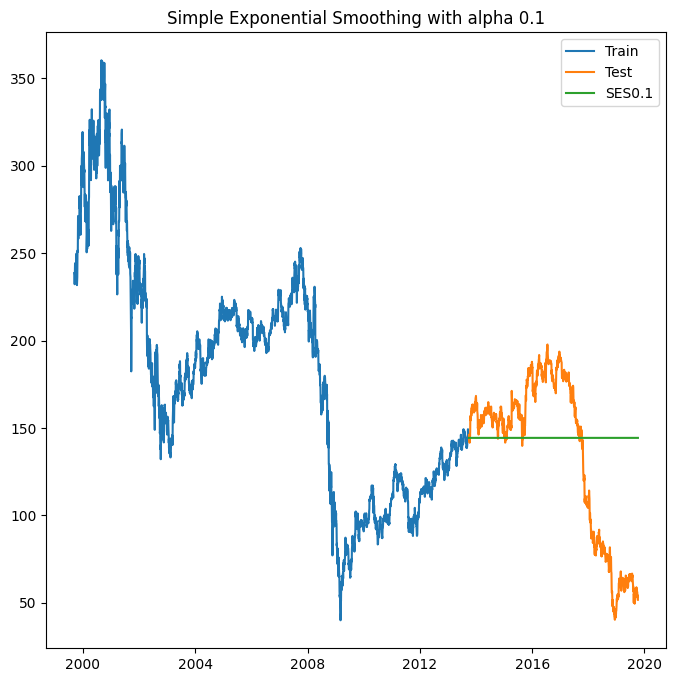

0.3
The MAPE value is : 27.52
The RMSE value is : 46.80617230179927




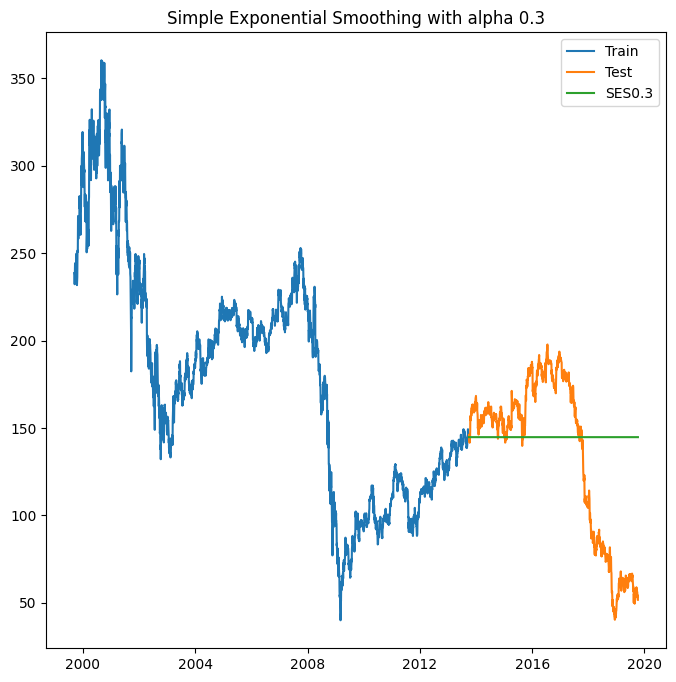

0.5
The MAPE value is : 27.63
The RMSE value is : 46.71676264160656




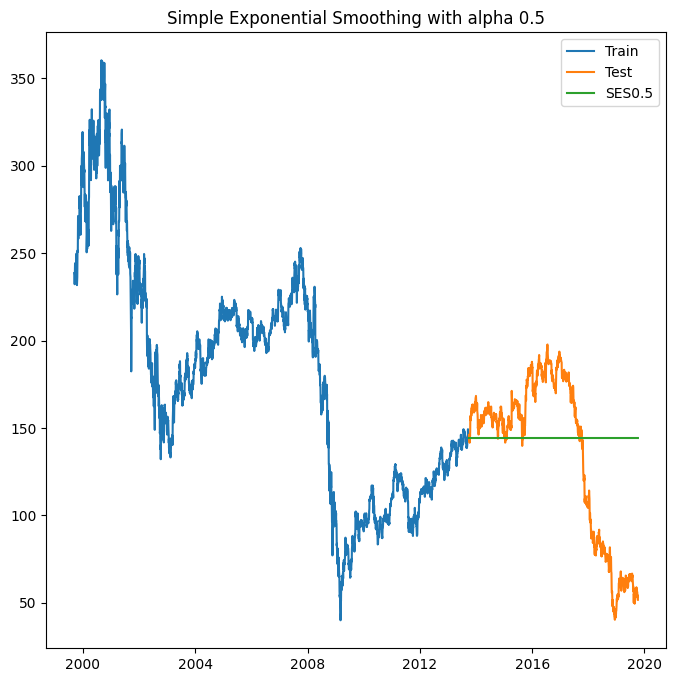

0.7
The MAPE value is : 27.72
The RMSE value is : 46.648383843680534




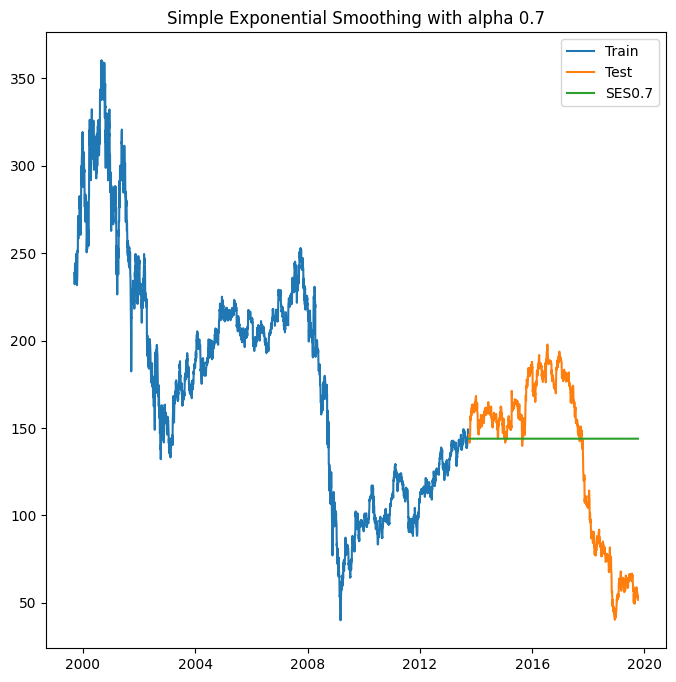

0.99
The MAPE value is : 27.81
The RMSE value is : 46.58426244663827




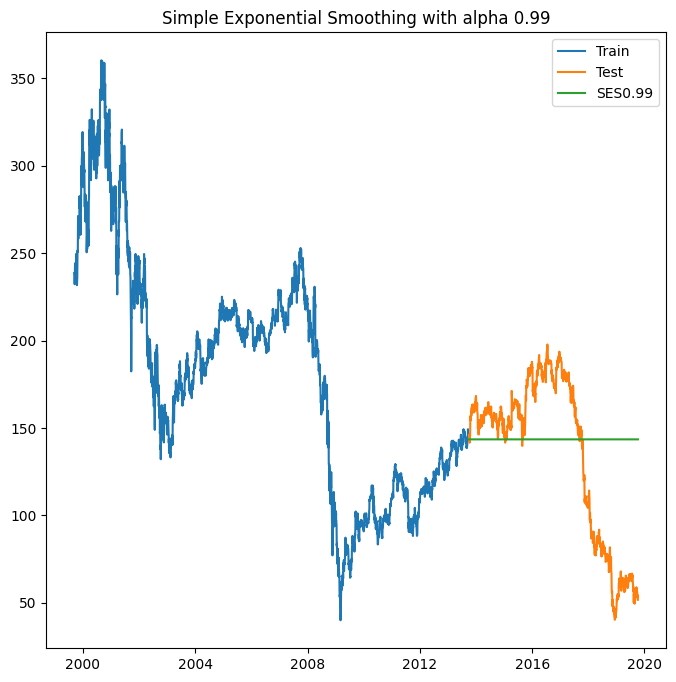

AttributeError: 'stockmodels' object has no attribute 'SES_2'

In [40]:
a=stockmodels(df_new)
a.traintestsplit()
#a.graphplot(test_esa['esa'])

#a.RMSE(test.Close,test_sa['avg_forecast'])
#a.MAPE(test.Close,test_sa['avg_forecast'])

#a.additive_SD()
a.multiplicative_SD()
a.naive_forecast()
a.simple_avg()
a.moving_avg()
a.exp_smooth()
a.SES_1()
a.SES_2()
a.TES_add()
a.TES_mul()
a.ARIMA_model()


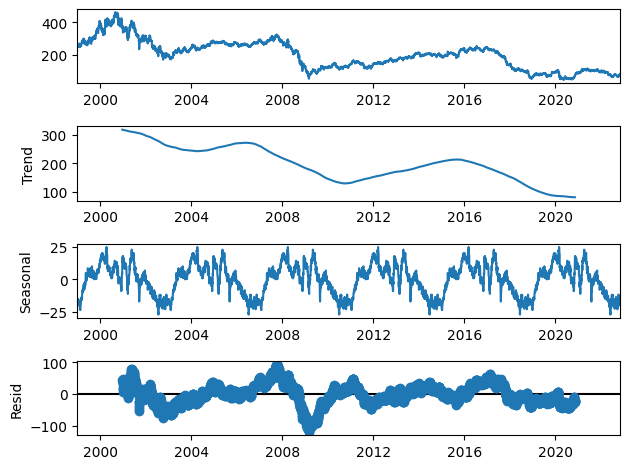

In [ ]:
##Additive Decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df_new,model='additive',period=1000)
result.plot()
plt.show()

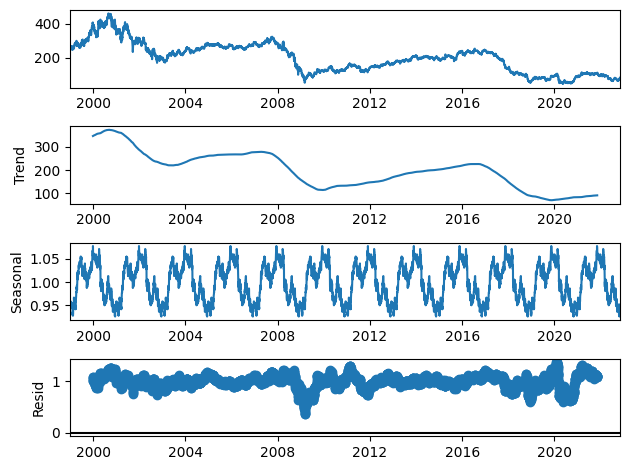

In [ ]:
result_m = seasonal_decompose(df_new, model='multiplicative', period=500)
result_m.plot()
plt.show()

ADF test

In [41]:
from statsmodels.tsa.stattools import adfuller
result_adf= adfuller(df_new,autolag='AIC')
print(f'ADF Statistic:{result_adf[0]}')
print(f'p-value:{result_adf[1]}')
print(f'nlag:{result_adf[2]}')
print(f'nobs:{result_adf[3]}')
for key, value in result_adf[4].items():
    print(f'Critical value: {key}, {value}')

ADF Statistic:-1.2557955814197903
p-value:0.6491456241638642
nlag:13
nobs:5038
Critical value: 1%, -3.4316486572066887
Critical value: 5%, -2.8621138670088118
Critical value: 10%, -2.5670754699409537


The p-value is greater then 0.05.
ADF statistic is higher than the critical values and hence we cannot reject the null hypothesis.

The time series in non-stationary.

#Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test

In [42]:
from statsmodels.tsa.stattools import kpss
result_kpss = kpss(df_new)
print(f'KPSS Statistic:{result_kpss[0]}')
print(f'p-value:{result_kpss[1]}')
print(f'nlag:{result_kpss[2]}')
for key, value in result_kpss[3].items():
    print(f'Critical value: {key}, {value}')

# print(result_kpss)

#Statistic, p-value, nlags, critical values = kpss(df_new, **kw)

KPSS Statistic:5.7739718337940005
p-value:0.01
nlag:42
Critical value: 10%, 0.347
Critical value: 5%, 0.463
Critical value: 2.5%, 0.574
Critical value: 1%, 0.739


The p-value is less than the alpha level (0.05). we reject the null hypothesis.

The series in not stationary

In [43]:
from statsmodels.tsa.stattools import kpss
result_kpss = kpss(df_new, regression='ct')
print(f'KPSS Statistic:{result_kpss[0]}')
print(f'p-value:{result_kpss[1]}')
print(f'nlag:{result_kpss[2]}')
for key, value in result_kpss[3].items():
    print(f'Critical value: {key}, {value}')

# print(result_kpss)

#Statistic, p-value, nlags, critical values = kpss(df_new, **kw)


KPSS Statistic:0.8059223179383236
p-value:0.01
nlag:42
Critical value: 10%, 0.119
Critical value: 5%, 0.146
Critical value: 2.5%, 0.176
Critical value: 1%, 0.216


Split the dataset into test and train

In [44]:
#Creating Train and Test set
train = df_new[0:int(len(df_new)*0.7)] 
test = df_new[int(len(df_new)*0.7):]

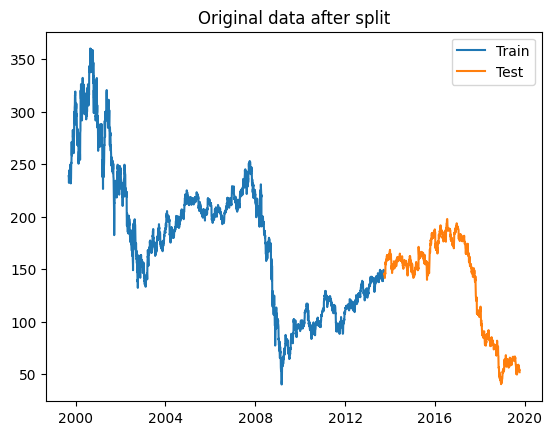

In [45]:
plt.plot(train, label = 'Train')
plt.plot(test,  label = 'Test')
plt.legend(loc = 'best')
plt.title('Original data after split')
plt.show()

Naive Forecast

In [ ]:
train_nf = np.asarray(train.Close)

test_nf = test.copy()
test_nf['Naive']=train_nf[len(train_nf)-1]

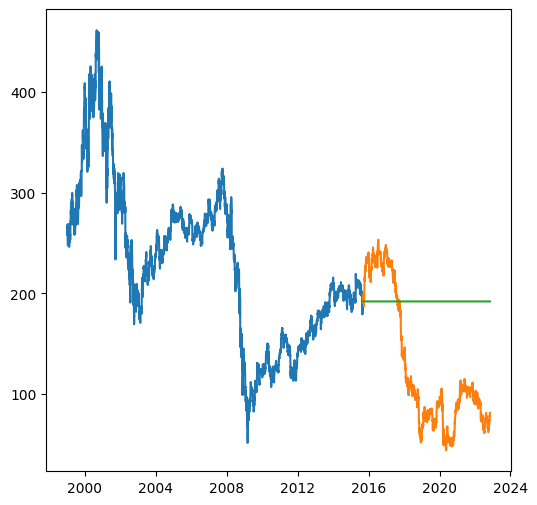

In [ ]:
plt.figure(figsize=(6,6))
plt.plot(train,label='Train')
plt.plot(test_nf['Close'], label = 'Test')
plt.plot(test_nf['Naive'], label='Naive Pred')

In [ ]:
rmse = RMSE(test_nf.Close,test_nf.Naive)
mape = MAPE(test_nf.Close,test_nf.Naive)

print(f'RMSE: {rmse},MAPE: {mape}')

RMSE: 91.84013237709684,MAPE: 65.25


Simple Average

In [ ]:
test_sa = test.copy()

,Close
Date,
2015-09-14,190.538467
2015-09-15,194.615387
2015-09-16,199.461533
2015-09-17,195.000000
2015-09-18,190.769226


In [ ]:
test_sa['avg_forecast']=train['Close'].mean()

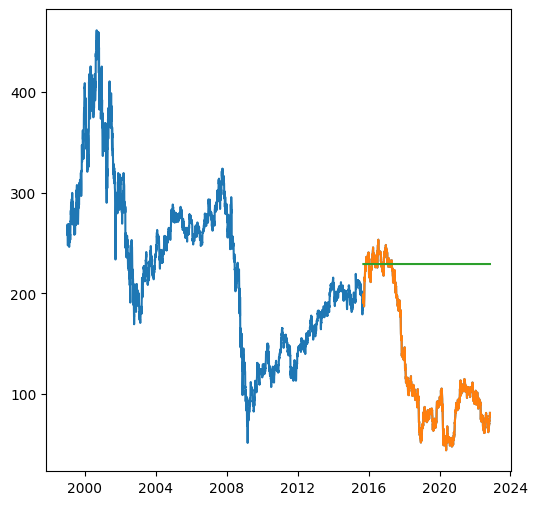

In [ ]:
plt.figure(figsize=(6,6))
plt.plot(df_new,label='Train')
plt.plot(test_sa['Close'], label='test')
plt.plot(test_sa['avg_forecast'], label='SA forecast')

In [ ]:
mape=MAPE(test['Close'], test_sa['avg_forecast'])
rmse=RMSE(test['Close'], test_sa['avg_forecast'])

print(mape, rmse)

The MAPE value is : 81.07
The RMSE value is : 120.78797358406092
None None


Moving Average

In [ ]:
df_ma = df_new.copy()

df_ma['ma_forecast_4']=df_ma['Close'].rolling(4).mean()
df_ma['ma_forecast_6']=df_ma['Close'].rolling(6).mean()
df_ma['ma_forecast_8']=df_ma['Close'].rolling(8).mean()
df_ma['ma_forecast_12']=df_ma['Close'].rolling(12).mean()

ma_cols = ['ma_forecast_4','ma_forecast_6','ma_forecast_8','ma_forecast_12']

#split the dataset into train and test
train=df_ma[0:int(len(df_ma)*0.7)]
test=df_ma[int(len(df_ma)*0.7):]

test_ma = test.copy()

2.150370472179159 1.22
2.8669373269004574 1.66
3.446266053872321 1.99
4.394813929927366 2.56


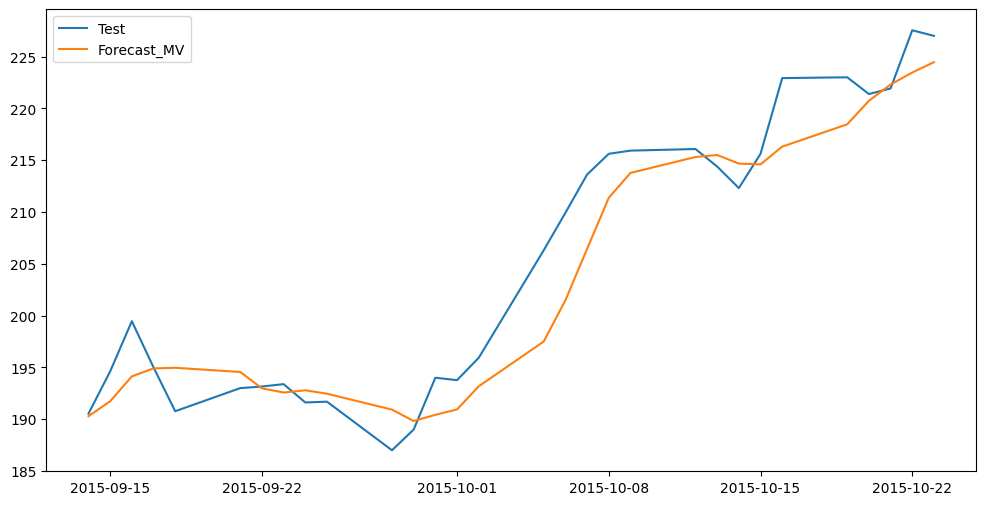

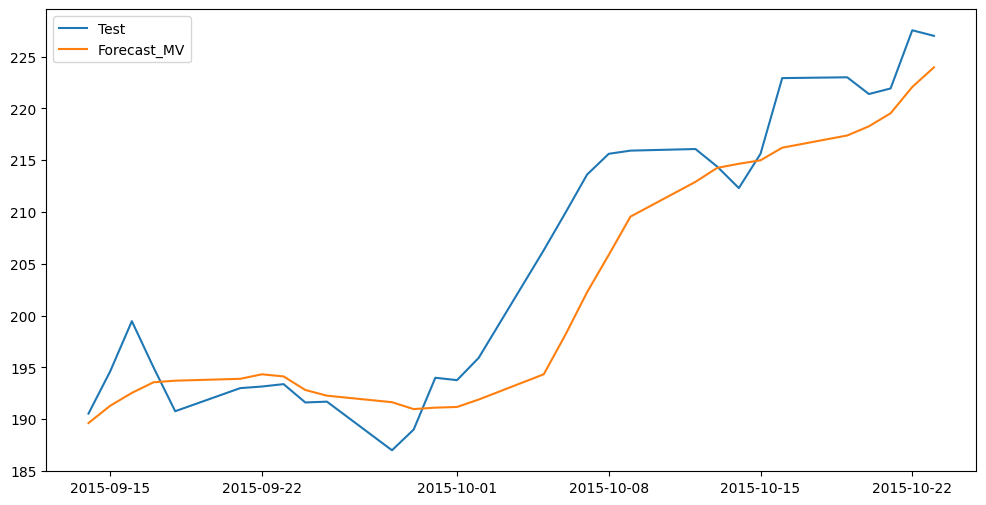

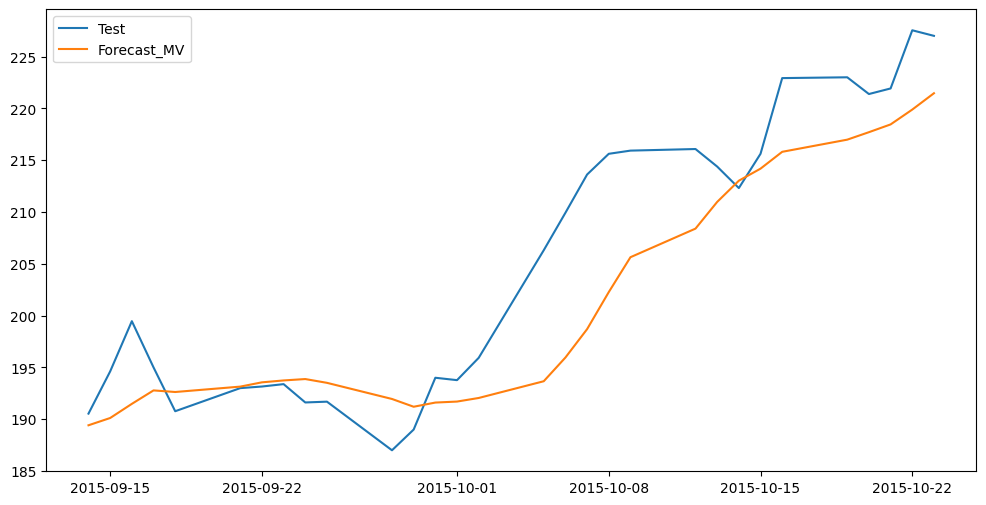

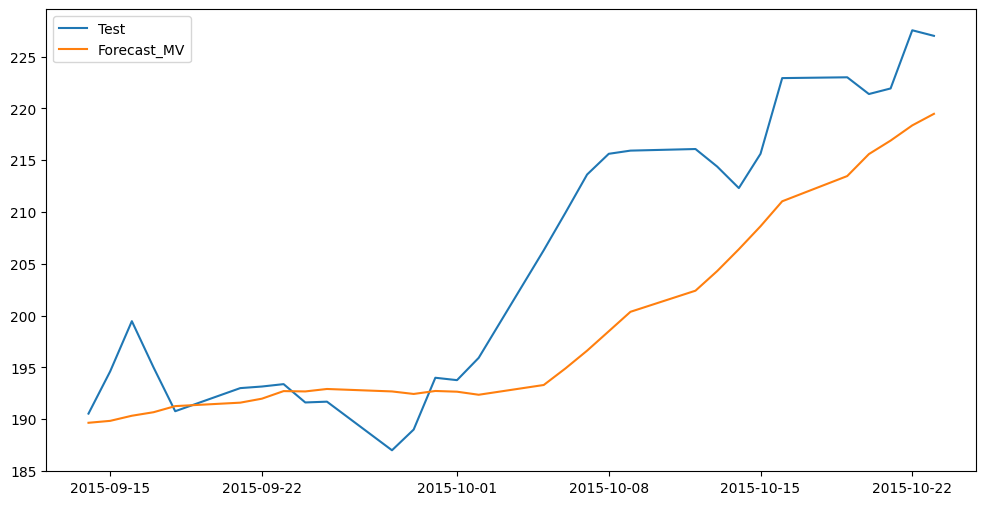

In [ ]:
for col_name in ma_cols:
    plt.figure(figsize=(12,6))
    #plt.plot(train['Close'][], label='Train')
    plt.plot(test['Close'][:30], label='Test')
    plt.plot(test[col_name][:30], label = 'Forecast_MV')
    plt.legend(loc='best')

    rmse =RMSE(test.Close, test[col_name])
    mape =MAPE(test.Close, test[col_name])

    print(rmse, mape)

Exponential Smoothing

In [ ]:
pred = ets.ExponentialSmoothing(df_new, trend=None, damped=False, seasonal=None).fit()
close_pred = pred.forecast(steps=7)
close_pred = pd.DataFrame(close_pred)
close_pred

/tmp/ipykernel_134478/496466741.py:1: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead.
  pred = ets.ExponentialSmoothing(df_new, trend=None, damped=False, seasonal=None).fit()
/home/rejeesh/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/rejeesh/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


,0
6002,81.005267
6003,81.005267
6004,81.005267
6005,81.005267
6006,81.005267
6007,81.005267
6008,81.005267


In [ ]:
pred_close1 = pred.predict(start=df_new.index[0])

rmse = np.sqrt(mean_squared_error(df_new, pred_close1))
mape = MAPE(df_new.Close, pred_close1)

In [ ]:
print(rmse,mape)

3.964688604289804 1.28


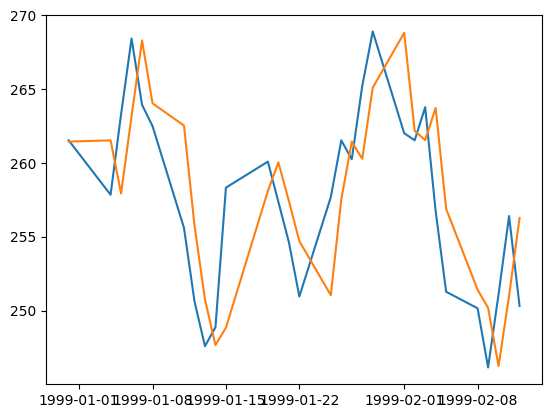

In [ ]:
fig1, ax = plt.subplots()
ax.plot(df_new[:30], label='actual')
ax.plot(pred_close1[:30], label='predicted')
plt.legend
plt.show()

In [ ]:
from   statsmodels.tsa.holtwinters     import  SimpleExpSmoothing

In [ ]:
#Create model
model = SimpleExpSmoothing(np.asarray(train['Close']))

In [ ]:
#Fitting the model
alpha_list = [0.1, 0.3, 0.5, 0.7, 0.99]

pred_SES  = test.copy() 

for alpha_value in alpha_list:
    alpha_str = "SES" + str(alpha_value)
    mode_fit_i = model.fit(smoothing_level = alpha_value, optimized=False)
    pred_SES[alpha_str] = mode_fit_i.forecast(len(test['Close']))
    
    rmse = np.sqrt(mean_squared_error(test['Close'], pred_SES[alpha_str]))
    mape = MAPE(test['Close'],pred_SES[alpha_str])

    print("For alpha = %1.2f,  RMSE is %3.4f MAPE is %3.2f" %(alpha_value, rmse, mape))

    ## Should plot the individual fit graphs here

For alpha = 0.10,  RMSE is 91.2485 MAPE is 64.94
For alpha = 0.30,  RMSE is 90.4711 MAPE is 64.54
For alpha = 0.50,  RMSE is 90.9790 MAPE is 64.80
For alpha = 0.70,  RMSE is 91.3676 MAPE is 65.00
For alpha = 0.99,  RMSE is 91.8256 MAPE is 65.24


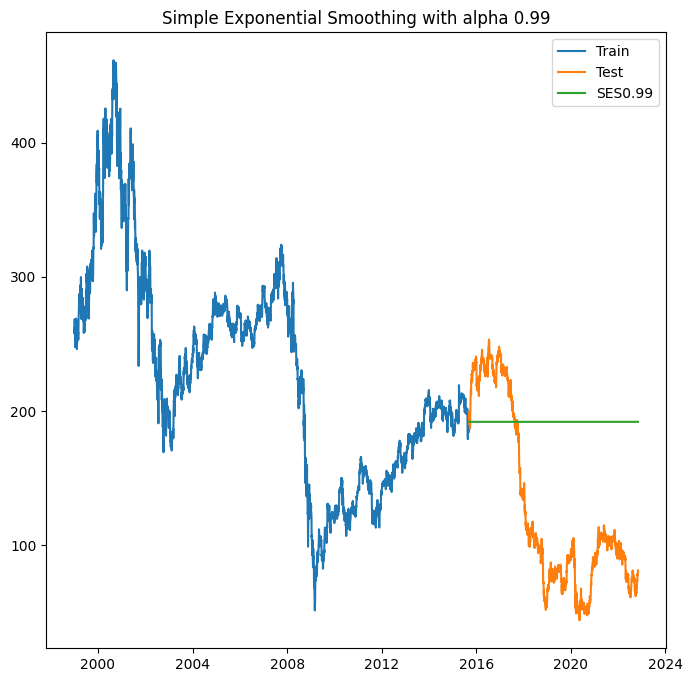

In [ ]:
plt.figure(figsize=(8,8))
plt.plot(train, label ='Train')
plt.plot(test, label  ='Test')
plt.plot(pred_SES[alpha_str], label  = alpha_str)
plt.title('Simple Exponential Smoothing with alpha ' + str(alpha_value))
plt.legend(loc='best') 
plt.show()

Double Exponential Smoothing

In [ ]:
from   statsmodels.tsa.holtwinters     import  Holt

In [ ]:
model = Holt(np.asarray(train))

model_fit = model.fit()

alpha_value = np.round(model_fit.params['smoothing_level'], 4)
#print('Initial Level',   np.round(model_fit.params['initial_level'], 4))
print('Alpha Value', alpha_value )

Alpha Value 0.9695


In [ ]:
Pred_Holt = test.copy()

Pred_Holt['Opt'] = model_fit.forecast(len(test['Close']))

In [ ]:
df_pred_opt =  pd.DataFrame({'Y_hat':Pred_Holt['Opt'] ,'Y':test['Close'].values})

rmse_opt =  np.sqrt(mean_squared_error(df_pred_opt.Y, df_pred_opt.Y_hat))
mape_opt =  MAPE(df_pred_opt.Y, df_pred_opt.Y_hat)

print("For alpha = %1.2f,  RMSE is %3.4f MAPE is %3.2f" %(alpha_value, rmse_opt, mape_opt))

For alpha = 0.97,  RMSE is 76.7893 MAPE is 55.39


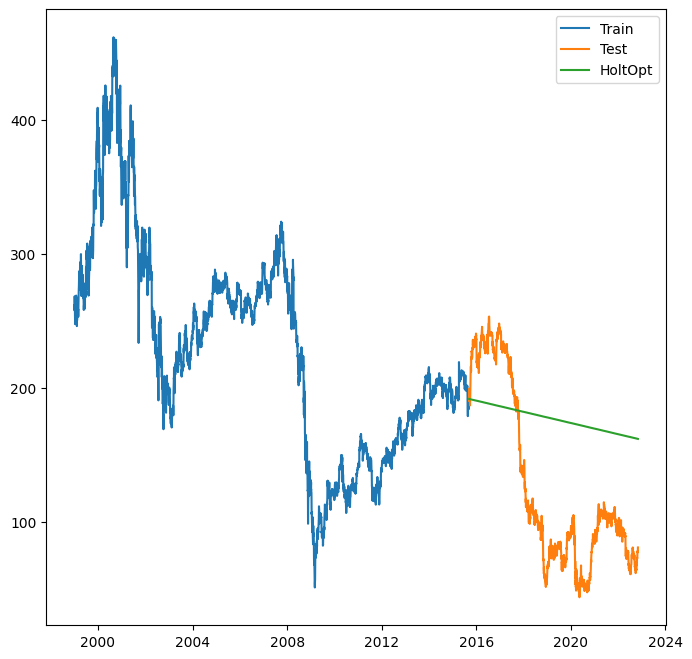

In [ ]:
plt.figure(figsize=(8,8))
plt.plot(train['Close'], label='Train')
plt.plot(test['Close'], label='Test')
plt.plot(Pred_Holt['Opt'], label='HoltOpt')
plt.legend(loc='best')
plt.show()

Triple Exponential Smoothing - Additive

In [ ]:
from   statsmodels.tsa.holtwinters import ExponentialSmoothing

In [ ]:
test_esa = test.copy()
model_esa = ExponentialSmoothing(np.asarray(train['Close']),seasonal_periods=2000, trend='add',seasonal='add').fit()

/home/rejeesh/.local/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [ ]:
test_esa['esa'] = model_esa.forecast(len(test_esa))

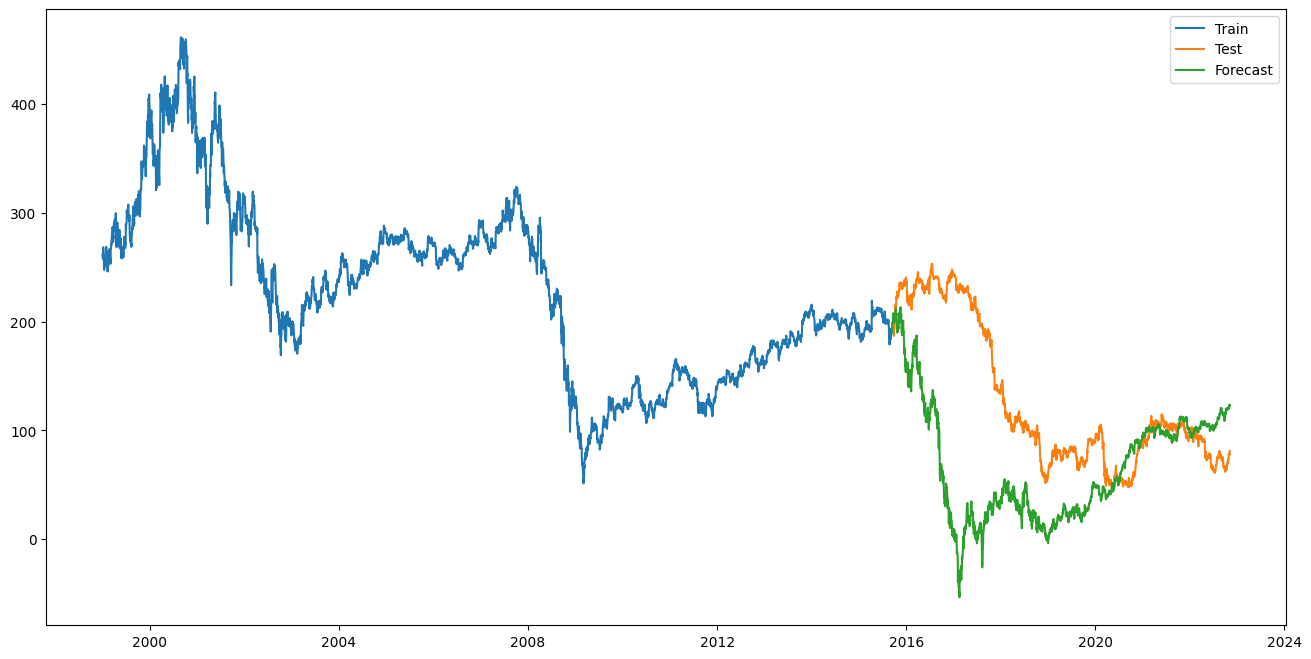

In [ ]:
graphplot(test_esa['esa'])

In [ ]:
alpha_value = np.round(model_esa.params['smoothing_level'], 4)
#beta_value  = np.round(model_esa.params['smoothing_slope'], 4)
gamma_value = np.round(model_esa.params['smoothing_seasonal'], 4)

print(f'{alpha_value},{gamma_value}')

0.9705,0.0


Triple Exp Smoothing - Multiplicative

In [ ]:
test_esm=test.copy()

In [ ]:
model_esm = ExponentialSmoothing(np.asarray(train['Close']),seasonal_periods=2000, trend='add',seasonal='multiplicative').fit()
test_esm['esm'] = model_esm.forecast(len(test_esm))

/home/rejeesh/.local/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


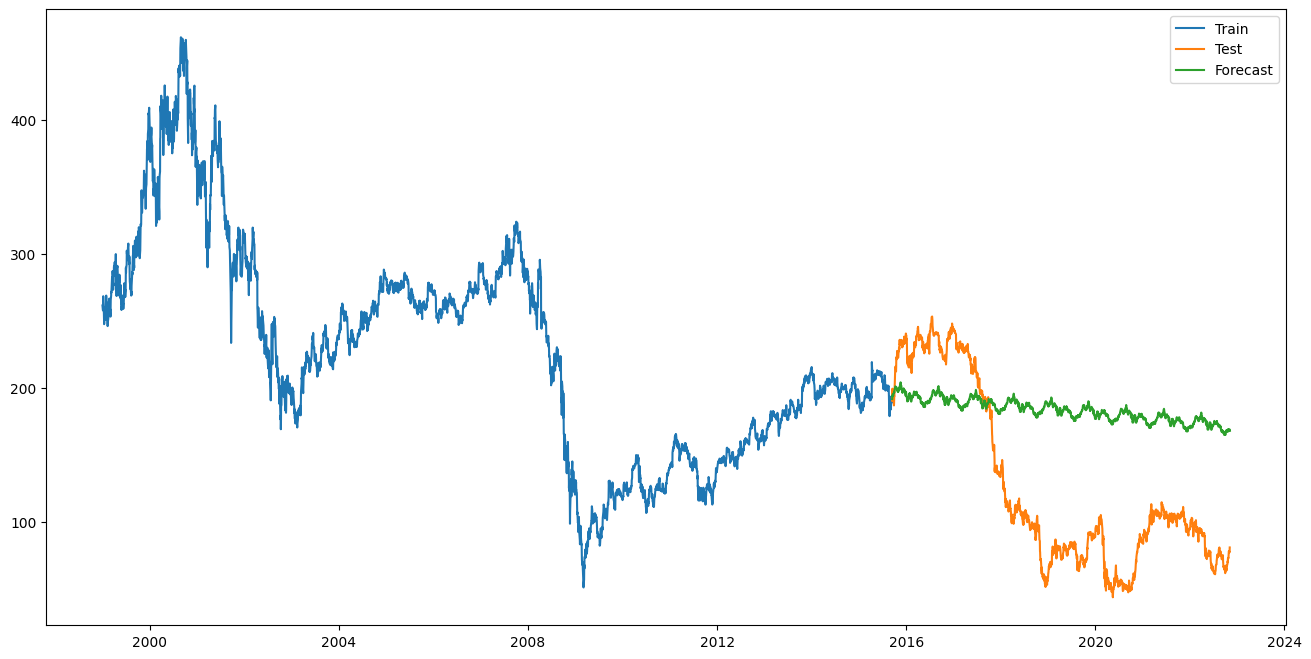

In [ ]:
graphplot(test_esm['esm'])

In [ ]:
alpha_value = np.round(model_esm.params['smoothing_level'], 4)
beta_value  = np.round(model_esm.params['smoothing_slope'], 4)
gamma_value = np.round(model_esm.params['smoothing_seasonal'], 4)

print(f'{alpha_value},{gamma_value}')

KeyError: 'smoothing_slope'

In [ ]:
#Determing rolling statistics

rolmean = df_new.rolling(window = 5).mean()
rolstd = df_new.rolling(window = 5).std()

Text(0.5, 1.0, 'Rolling Mean & Standard Deviation')

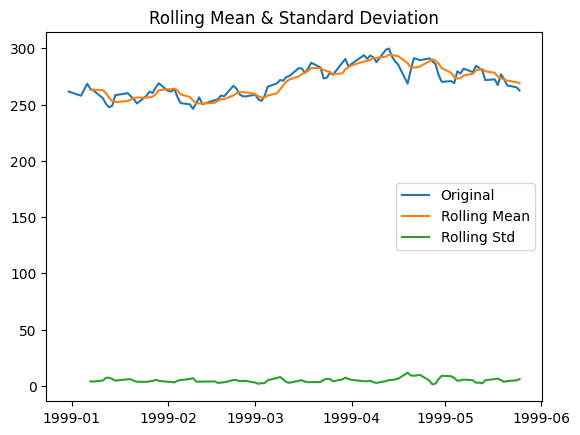

In [ ]:
#Plot rolling statistics:
orig = plt.plot(df_new[:100], label='Original')
mean = plt.plot(rolmean[:100], label='Rolling Mean')
std = plt.plot(rolstd[:100], label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')

Text(0, 0.5, 'Stocks Close')

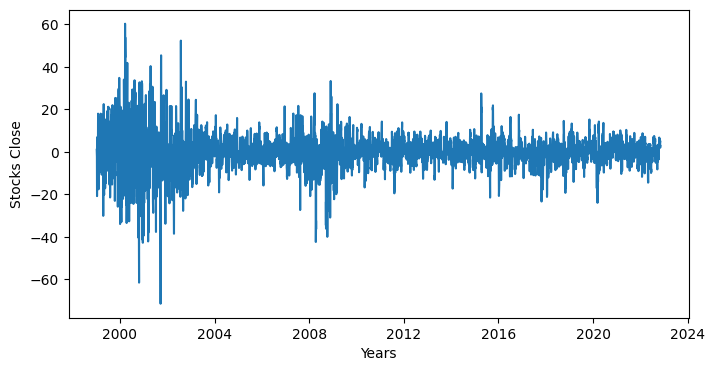

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(df_new.diff(periods=5))
plt.xlabel('Years')
plt.ylabel('Stocks Close')

Text(0, 0.5, 'Log (stock Close)')

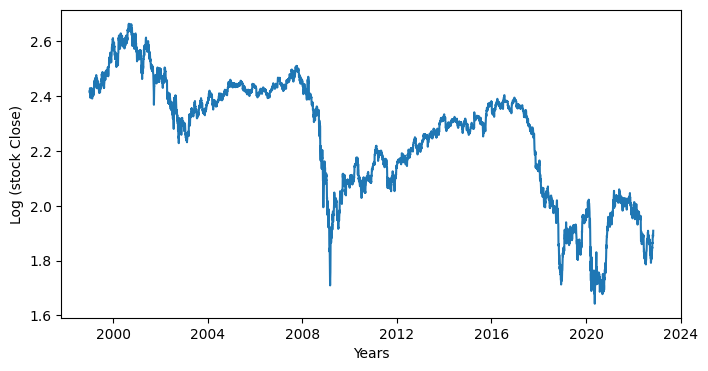

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(np.log10(df_new))
plt.xlabel('Years')
plt.ylabel('Log (stock Close)')

Text(0, 0.5, 'Differenced Log (Stock Close)')

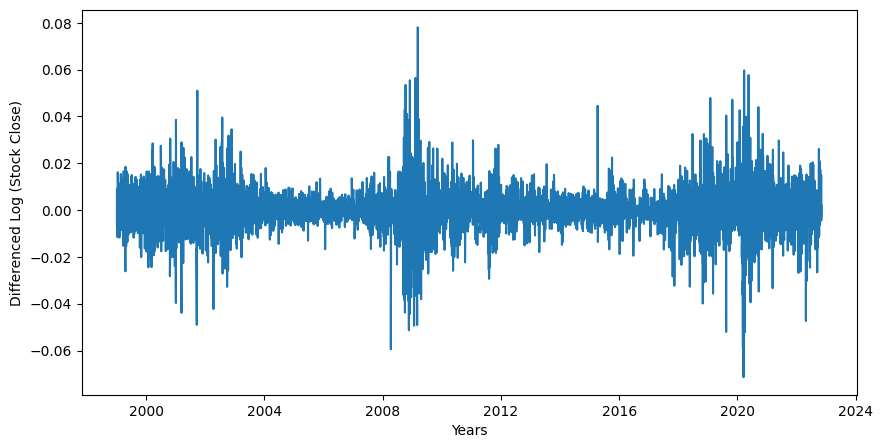

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(np.log10(df_new).diff(periods=1))
plt.xlabel('Years')
plt.ylabel('Differenced Log (Stock Close)')

In [ ]:
close_log = np.log10(df_new)
close_log.dropna(inplace=True)

close_log_diff = close_log.diff(periods=1) # same as ts_log_diff = ts_log - ts_log.shift(periods=1)
close_log_diff.dropna(inplace=True)

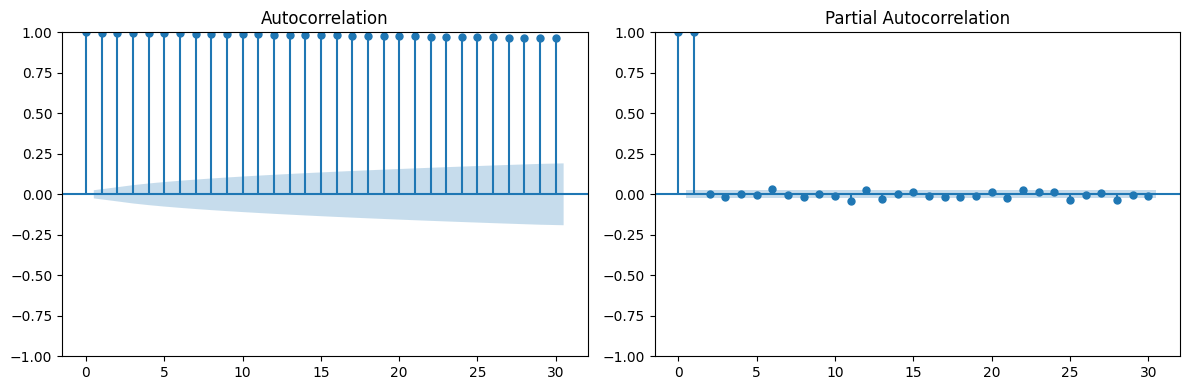

In [ ]:
fig, axes = plt.subplots(1, 2)
fig.set_figwidth(12)
fig.set_figheight(4)
smt.graphics.plot_acf(close_log, lags=30, ax=axes[0])
smt.graphics.plot_pacf(close_log, lags=30, ax=axes[1])
plt.tight_layout()

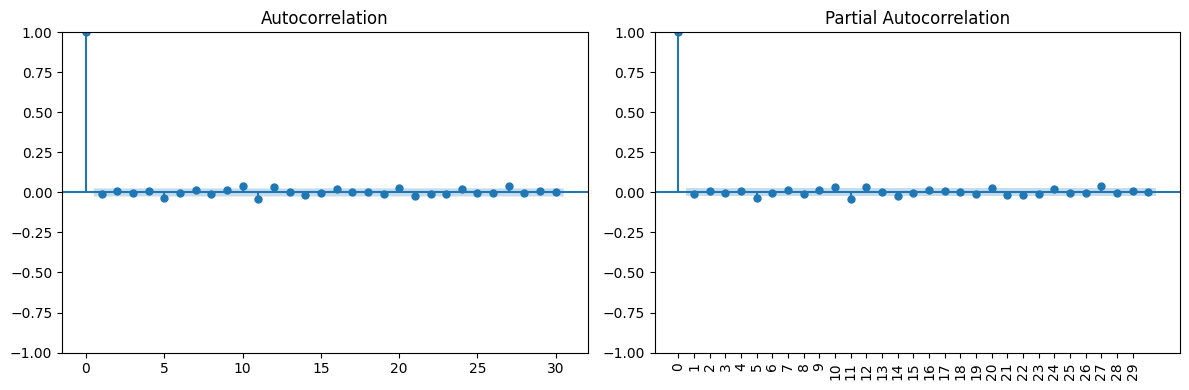

In [ ]:
fig, axes = plt.subplots(1, 2)
fig.set_figwidth(12)
fig.set_figheight(4)
plt.xticks(range(0,30,1), rotation = 90)
smt.graphics.plot_acf(close_log_diff, lags=30, ax=axes[0])
smt.graphics.plot_pacf(close_log_diff, lags=30, ax=axes[1])
plt.tight_layout()

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=24562.316, Time=0.21 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=24561.285, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=24560.870, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=24560.373, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=24550.093, Time=1.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=24549.293, Time=1.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=24547.685, Time=0.35 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=24549.376, Time=0.96 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=24551.291, Time=1.76 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=24545.754, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=24559.345, Time=0.06 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=24547.443, Time=0.24 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=24547.362, Time=0.26 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=24548.176, Time=0.30 sec
 ARIMA(3,1,1)(0,0,0

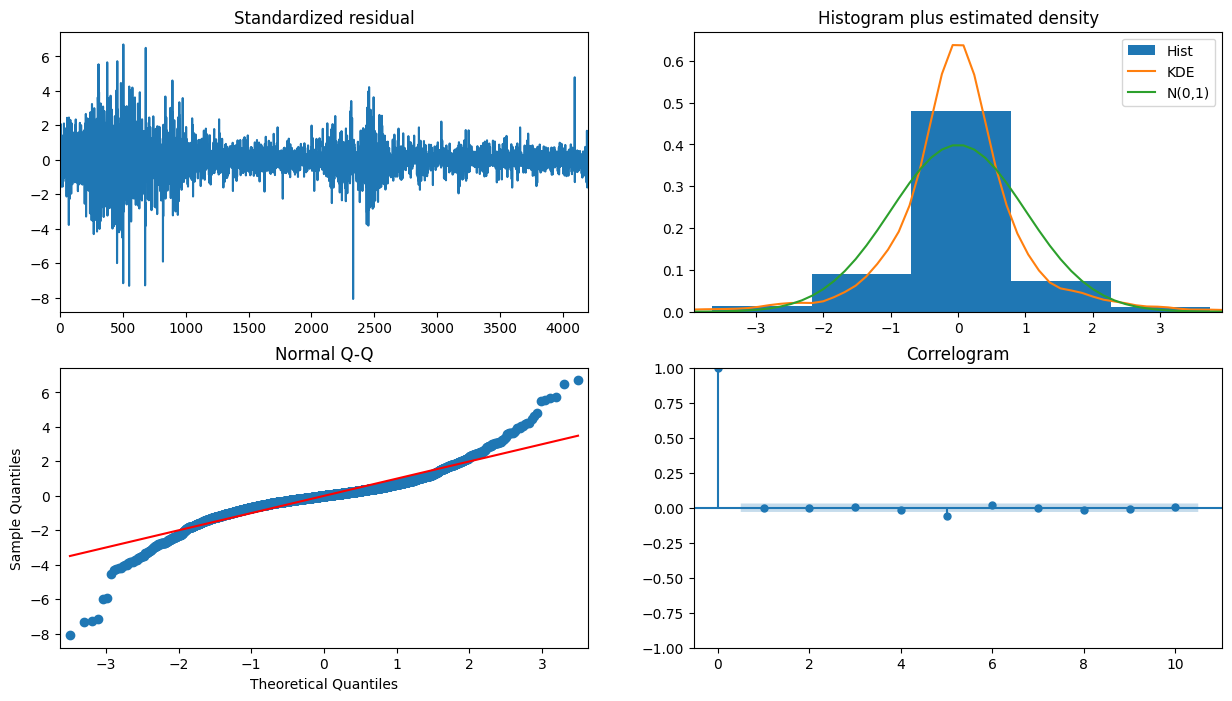

In [ ]:
model_autoARIMA = auto_arima(train, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [ ]:
model = sm.tsa.arima.ARIMA(train, order=(2,1,0))  
fitted = model.fit()  
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 4201
Model:                 ARIMA(2, 1, 0)   Log Likelihood              -12269.877
Date:                Thu, 10 Nov 2022   AIC                          24545.754
Time:                        17:03:03   BIC                          24564.782
Sample:                             0   HQIC                         24552.482
                               - 4201                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0285      0.009     -3.286      0.001      -0.045      -0.011
ar.L2         -0.0609      0.009     -6.845      0.000      -0.078      -0.043
sigma2        20.1843      0.200    100.695      0.0

In [ ]:
# Forecast
fc = fitted.forecast(1801, alpha=0.3)  # 95% conf

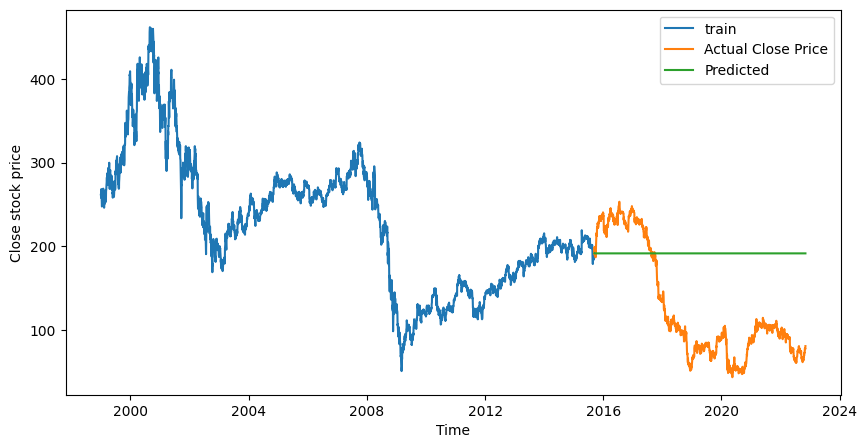

In [ ]:
#Make as pandas series
fc.index=test.index
fc_series = fc.copy()

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train, label='train')
plt.plot(test, label='Actual Close Price')
plt.plot(fc_series,label='Predicted')
plt.xlabel('Time')
plt.ylabel('Close stock price')
plt.legend(loc='best')
plt.show()

In [ ]:
a.score(test.Close,fc_series)


The MAPE value is : 65.16
The RMSE value is : 91.68231143194096


In [ ]:
model = sm.tsa.arima.ARIMA(train, order=(2,1,0))  
fitted = model.fit()  
print(fitted.summary())

AttributeError: module 'statsmodels.tsa.arima.api' has no attribute 'ARMA'

In [ ]:
best_model = sm.tsa.statespace.SARIMAX(train_log,
                                      order=(2, 1, 0),
                                      seasonal_order=(0, 0, 0, 0),
                                      enforce_stationarity=True)
best_results = best_model.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.33685D+00    |proj g|=  1.45661D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      1      8      1     0     0   1.279D-01  -3.337D+00
  F =  -3.3368456978841254     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.
